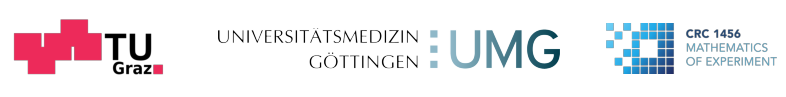

In [28]:
exec(open('src/plot_fun.py').read())
plot_header()

# Quantitative Magnetic Resonance Imaging of the NIST Phantom

Heide, Martin$^1$, Scholand, Nick$^2$, Uecker, Martin$^{1,2}$

$^1$ University Medical Center, Göttingen, $^2$ Graz University of Technology, Austria

Subproject  [B03 - Low-rank and sparsity-based models in Magnetic Resonance Imaging](https://www.uni-goettingen.de/en/630810.html), CRC1456. Magnetic resonance imaging dataset of the T1 layer of the NIST Phantom Model 106 (https://doi.org/10.1002/mrm.28779) acquired with inversion-recovery balanced steady-state free-precession (IR-bSSFP), inversion-recovery fast low angle shot (IR-FLASH) sequences, inversion-recovery single-echo spin echo, single-echo spin echo, gradient echo and FLASH-based B1 mapping sequence with preconditioning RF pulse. The files are intended to be used with the Berkeley Advanced Reconstruction Toolbox (https://doi.org/10.5281/zenodo.592960). Each dataset consists of a ASCII Text-encoded header (.hdr) and a binary-encoded complex float file (.cfl). [Data and detailed description of sequence parameters.](https://data.goettingen-research-online.de/dataverse/qmri_nist) 

[![badge](https://img.shields.io/badge/B03%20QMRI%20NIST%20Phantom-Launch%20Binder-579ACA.svg?logo=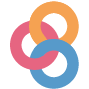)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.gwdg.de%2Fmartin.heide%2Fb03-goldstandard-mri/HEAD)
[![static-html](https://img.shields.io/badge/B03%20QMRI%20NIST%20Phantom%20-%20Static%20HTML%20-%20white)](https://b03-goldstandard-mri-martin-heide-3253387a7dad99658c10e839d9819.pages.gwdg.de/)


The Bloch equation is the model in MRI and describes the behaviour of the net magnetizations $M(p,t)\in\mathbb{R}^3$ of hydrogen proton spins at $p\in\mathbb{R}^3$ under the action of magnetic fields $B(p,t)\in\mathbb{R}^3$ depending on tissue-specific constants $T_1(p),T_2(p) > 0$ for $t\geq t_0\in\mathbb{R}$

$$
\frac{d M(p,t)}{dt} = M(p,t)\times \gamma B(p,t) - \left ( \frac{M_x(p,t)}{T_2(p)}, \frac{M_y(p,t)}{T_2(p)}, \frac{M_z(p,t) -M_z(p,t_0)}{T_1(p)}\right)^T,
$$

and $\gamma > 0$ denote the gyromagnetic ratio of hydrogen. The field $B(p,t)$ is composed of various superpositions of the main magnetic field $B_0$, the excitation pulse $B_1$ and gradient field $G$ depending on $t\in\mathbb{R}$. The acquired signal is affected by physical effects like off-resonances or field inhomogeneities of $B_0,B_1$ which are not included in the Bloch model. We present computational results for estimations of $B_0,B_1,T_1,T_2$ from measurements. The measurement sequences used to obtain the data are supposed to compensate for off-resonances and enable one to obtain reproducible results.

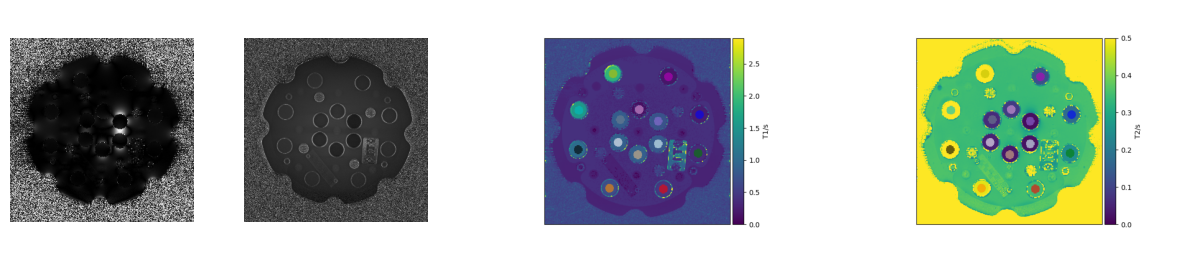

In [27]:
exec(open('src/plot_fun.py').read())
plot_all_maps()

## Setup of Software and Data

Download and install the latest version of [BART](https://mrirecon.github.io/bart/)

In [41]:
%%bash
rm -rf bart
git clone https://github.com/mrirecon/bart/ bart &> /dev/null
echo "PARALLEL=1" > bart/Makefiles/Makefile.local
cd bart && make &> /dev/null && ./bart version

Download the [datasets](https://data.goettingen-research-online.de/dataverse/qmri_nist).

In [7]:
%%bash
rm -rf resources && mkdir resources
wget -q -O resources/data.zip "data.goettingen-research-online.de/api/access/dataset/:persistentId/?persistentId=doi:10.25625/FSLMYU"
unzip -q -o resources/data.zip -d resources

rm -rf reconstructions && mkdir reconstructions

## Estimation of $B_0$ field map

In [8]:
%%bash
export PATH=$PWD/bart:$PATH
W=wdir_b0
rm -rf $W && mkdir $W

# estimate coil sensitivity profiles
bart ecalib -c 0 -m 1 resources/data_b0_gre $W/sens

# phase preserving reconstruction
bart pics -e -S -d 0 resources/data_b0_gre $W/sens $W/_reco

SAMPLES=$(bart show -d 0 $W/_reco)
bart resize -c 0 $((SAMPLES/2)) $W/_reco $W/reco

bart slice 5 0 $W/reco $W/te1
bart slice 5 1 $W/reco $W/te2

TE1=0.00492	# Early TE
TE2=0.00738	# Late TE

# Estimate B0 = phase(reco(TE2) * conj(reco(TE2))) / (TE2 - TE1)
# Nayak & Nishimura, MRM, 2000.
bart conj $W/te1 $W/te1c
bart fmac $W/te2 $W/te1c $W/p
bart carg $W/p $W/ph
bart scale -- $(echo $TE1 $TE2 | awk '{printf "%f\n", -1/($2-$1)}') $W/ph reconstructions/b0map

bart flip 1 reconstructions/b0map $W/b0map_t
bart toimg $W/b0map_t figures/b0map

Done.
Writing 1 image(s)...done.


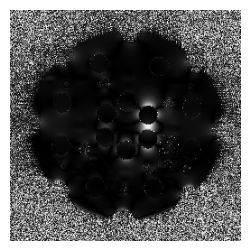

In [9]:
exec(open('src/plot_fun.py').read())
plot_b0map()

## 2 Estimation of $B_1$ field map

In [10]:
%%bash
export TOOLBOX_PATH=$PWD/bart
export PATH=$TOOLBOX_PATH:$PATH
W=wdir_b1
rm -rf $W && mkdir $W

# B1+ Mapping with Siemens Sequence "tfl_b1map" based on
# Chung, S., Kim, D., Breton, E. and Axel, L. (2010),
# Rapid B1+ mapping using a preconditioning RF pulse with TurboFLASH readout.
# Magn. Reson. Med., 64: 439-446.
# https://doi.org/10.1002/mrm.22423

# Compensate for asymetric echo
## Mirror kspace to fill missing lines
FREQ_ASYM=$(bart show -d 0 resources/data_b1_precond)
PHASE=$(bart show -d 1 resources/data_b1_precond)
DIFF=$(($((PHASE*2))-FREQ_ASYM))

bart extract 0 $((FREQ_ASYM-DIFF)) $FREQ_ASYM resources/data_b1_precond $W/miss

bart flip $(bart bitmask 0) resources/data_b1_precond $W/tmp
bart join 0 $W/tmp $W/miss $W/_raw
bart flip $(bart bitmask 0) $W/_raw $W/raw

# Estimate coil sensitivity profiles
bart ecalib -c 0 -m 1 $W/raw $W/sens

# Phase preserving reconstruction
bart pics  -e -S -d 0 $W/raw $W/sens $W/_reco
SAMPLES=$(bart show -d 0 $W/_reco)
bart resize -c 0 $PHASE $W/_reco $W/reco

bart slice 11 0 $W/reco $W/pd
bart slice 11 1 $W/reco $W/pre

bart invert $W/pd $W/pdi
bart fmac $W/pre $W/pdi $W/tmp

# Calculate: arccos(SSPre / PD)
python3 src/arccos.py $W/tmp $W/acos

FA_NOM=80 # [deg] Just from raw data..., IDEA internal... -> vim *.dat and /PrepFlipAngle

# Calculate: kappa = arccos(SSPre / PD) / FA_NOM = b1map
bart scale -- $(echo $FA_NOM | awk '{printf "%f\n", 1/(3.141592653589793 * $1 / 180)}') $W/acos reconstructions/b1map

# visualization
bart flip 1 reconstructions/b1map $W/b1map_t
bart toimg $W/b1map_t figures/b1map

Done.
Writing 1 image(s)...done.


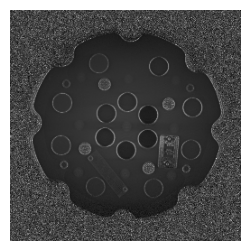

In [24]:
exec(open('src/plot_fun.py').read())
plot_b1map()

## 3 Estimation of $T_1, T_2$

Under several assumptions, the longitudinal $M_z$ and transverse $M_\mathbb{C}$ solutions to the Bloch equations during the data acquisition read
$$
M_\mathbb{C}(p,t) = M_\mathbb{C}(p,t_0) e^{-t/T_2(p)} \\
M_z(p,t) = M_\mathbb{C}(p,t_0) (1 - e^{-t/T_2(p)})
$$
and the goal is to fit functions of this type to the measured data in order to obtain the quantitative parameter $T_1(p), T_2(p)$ for each pixel $p$.

In [12]:
%%bash
export TOOLBOX_PATH=$PWD/bart
export PATH=$TOOLBOX_PATH:$PATH
W=wdir_t1t2
rm -rf $W && mkdir $W

# Coil-wise reconstruct the dataset and coil-combine to a single dataset
bart fft -i 7 resources/data_GSM_t1 $W/tmp
bart resize -c 0 256 1 256 $W/tmp $W/reco
bart rss 8 $W/reco reconstructions/recoTI

# Coil-wise reconstruct the dataset and coil-combine to a single dataset
bart fft -i 7 resources/data_GSM_t2 $W/tmp
bart resize -c 0 256 1 256 $W/tmp $W/reco
bart rss 8 $W/reco reconstructions/recoTE

# Put echo times in milliseconds in file and convert to seconds
bart vec 12 20 30 40 70 100 150 200 250 350 $W/T2enc0
bart transpose 0 5 $W/T2enc0 $W/T2enc1
bart scale -- 0.001 $W/T2enc1 $W/T2enc
# Fit Model to data acquired at echo times
bart mobafit -T $W/T2enc reconstructions/recoTE $W/fit
# slice out relevant quantitative parameter
bart slice 6 1 $W/fit $W/mapR2
# compute T1 = 1/R2
bart invert $W/mapR2 reconstructions/mapT2

python3 src/t1_fit.py reconstructions/recoTI "35 75 100 125 150 250 1000 1500 2000 3000" $W/IRfit
bart slice 2 1 $W/IRfit reconstructions/mapT1

# do statistics of estimated quantitative values within the masks
#bart roistat -M resources/masks reconstructions/mapT1 $W/roi_mean_T1
#bart roistat -D resources/masks reconstructions/mapT1 $W/roi_std_T1
#bart roistat -M resources/masks reconstructions/mapT2 $W/roi_mean_T2
#bart roistat -D resources/masks reconstructions/mapT2 $W/roi_std_T2

# visualize estimated parameter maps and masks
python3 src/createqplot.py reconstructions/mapT2 0 0.5 "T2/s" figures/t2map.png
python3 src/createqplot.py reconstructions/mapT1 0 2.9 "T1/s" figures/t1map.png

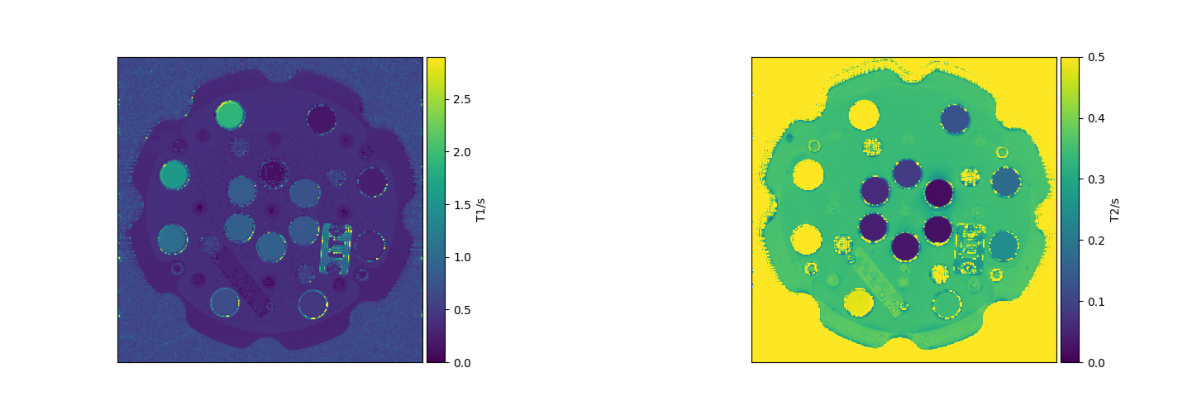

In [13]:
exec(open('src/plot_fun.py').read())
plot_qmaps()

## 4 Advanced estimation of $T_1$: The Look-Locker Model

More advanced method of estimating $T_1$.

In [2]:
%%bash
export TOOLBOX_PATH=$PWD/bart
export PATH=$TOOLBOX_PATH:$PATH
W=wdir_looklocker
rm -rf $W && mkdir $W

NPOINTS=$(bart show -d 0 resources/data_irflash)
ANGLE=7
NSPOKES=$(bart show -d 10 resources/data_irflash)
#echo $(bart show -d 1 resources/data_irflash)

#M=$(($(bart show -d 0 resources/data_irflash)/2))
#echo $NPOINTS
#echo $NSPOKES

# The data was acquired with 18 receiver coils. In order to reduce computational costs, compression to five coils is applied
bart cc -p 5 -A resources/data_irflash $W/k0
bart transpose 1 2 $W/k0 $W/k1
bart transpose 0 1 $W/k1 $W/k2

# create radial sampling trajectories with angle ANGLE between consecutive spokes
bart traj -x $NPOINTS -y 1 -s $ANGLE -c -G -t $NSPOKES -D -r $W/traj0

# we want to correct for gradient delays with RING (measurement imperfection: The sampled data belongs actually to slightly shifted trajectories)
# for gradient delay estimation we take data on 150 spokes
bart extract 10 $((NSPOKES-150)) $NSPOKES resources/data_irflash $W/d0
bart extract 10 $((NSPOKES-150)) $NSPOKES $W/traj0 $W/traj1
bart transpose 2 10 $W/d0 $W/d1
bart transpose 2 10 $W/traj1 $W/traj2
bart flip 4 $W/d1 $W/d2
bart flip 4 $W/traj2 $W/traj3
#bart traj -x $NPOINTS -y 1 -s $ANGLE -c -G -t $NSPOKES -D -r -O -q $(bart estdelay $W/traj3 $W/d2) $W/traj4

In [1]:
%%bash
# gitlab pipeline complains about exceeding artifact size, so we delete some data
rm -rf resources
rm -rf reconstructions
rm -rf wdir_b0
rm -rf wdir_b1
rm -rf wdir_t1t2
rm -rf wdir_looklocker